# Foundations of Data Mining: Assignment 2

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 120 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides
# InteractiveShell.ast_node_interactivity = "all" 

In [2]:
# This is a temporary read-only OpenML key. Replace with your own key later. 
oml.config.apikey = os.environ.get('OPENMLKEY','dbff1b32a2bae0db0fc7c561cd8bb544')

## Kernel selection (4 points (1+2+1))
SVMs can be trained with different kernels. Generate a 2-dimensional dataset as shown below and study the effect of the choice of kernel by visualizing the results.

- Train a SVM classifier on the dataset using respectively a linear, polynomial and radial basis function (RBF) kernel, evaluate the performance of each kernel using 10-fold cross-validation and AUC. Which one works best? Visualize the results. Can you intuitively explain why one kernel is more suited than another?
    - Hint: you can use the visualization code used in class. It is under mglearn/plot_svm.py > plot_svm_kernels().
- Take the RBF kernel and vary both the C parameter and the kernel width ($\gamma$). Use 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. 
    - Hint: don't count the support vectors manually, retrieve them from the trained SVM.
- Vary C and $\gamma$ again, but this time use a grid of at least 20x20, vary both parameters uniformly on a log scale, and visualise the results using a $C \times \gamma \rightarrow AUC$ heatmap. Explain the performance results, and compare them to the 9 results obtained in the previous subquestion. Can you also tell in which regions of the heatmap you are over/underfitting?
    - Hint: We've constructed such a heatmap in class and in assignment 1.

In [3]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     cross_val_score, train_test_split)
X, y = make_blobs(centers=2, n_samples=1000, random_state=0)


def plot_svm(clf):
    mglearn.plots.plot_2d_separator(clf, X, eps=.5)
    mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
    sv = clf.support_vectors_
    sv_labels = clf.dual_coef_.ravel() > 0
    mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
    
    x_min = -2
    y_min = -3
    x_max = 6
    y_max = 9
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    dec = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]);
    plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);




AUC Scores of SVM with kernel 'linear': 0.99364

AUC Scores of SVM with kernel 'poly': 0.99288

AUC Scores of SVM with kernel 'rbf': 0.97680


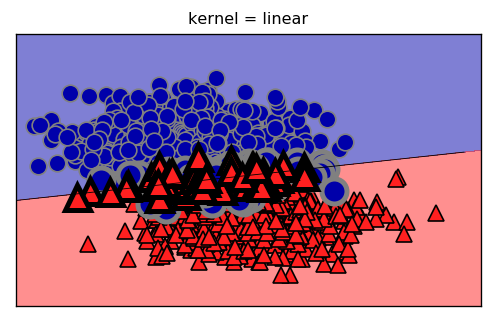

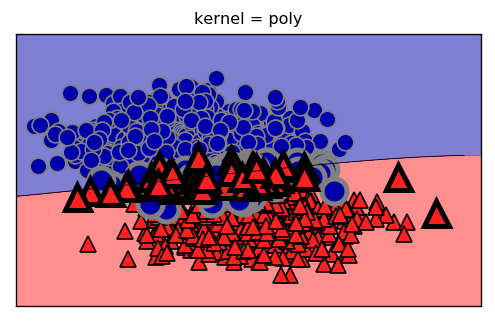

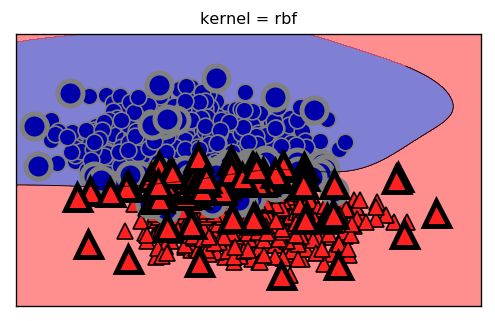

In [4]:
from sklearn.svm import SVC
for kernel in ['linear', 'poly', 'rbf']:
    clf = SVC(kernel=kernel);
    clf.fit(X, y);
    plt.figure();
    plt.title('kernel = {}'.format(kernel));
    print("\nAUC Scores of SVM with kernel '%s': %.5f" % (kernel, cross_val_score(clf, X, y, cv=10, scoring='roc_auc').mean()))
    plot_svm(clf)
plt.show()


The result shows that the linear kernel works best, the polynomial kernel is almost good as linear model, yet the performance of 'rbf' kernel is the worst. This is because the blobs are generated on two centers and are both in Gaussian destribution, resulting a linear boundary for two groups of blobs. So that the data can be modeled best by linear kernel. While the rbf kernel produce a curving line to separate the blobs, which leads to overfitting. The actual boundary depends on the support vectors, which is the reason why 'rbf' has lower scores. 

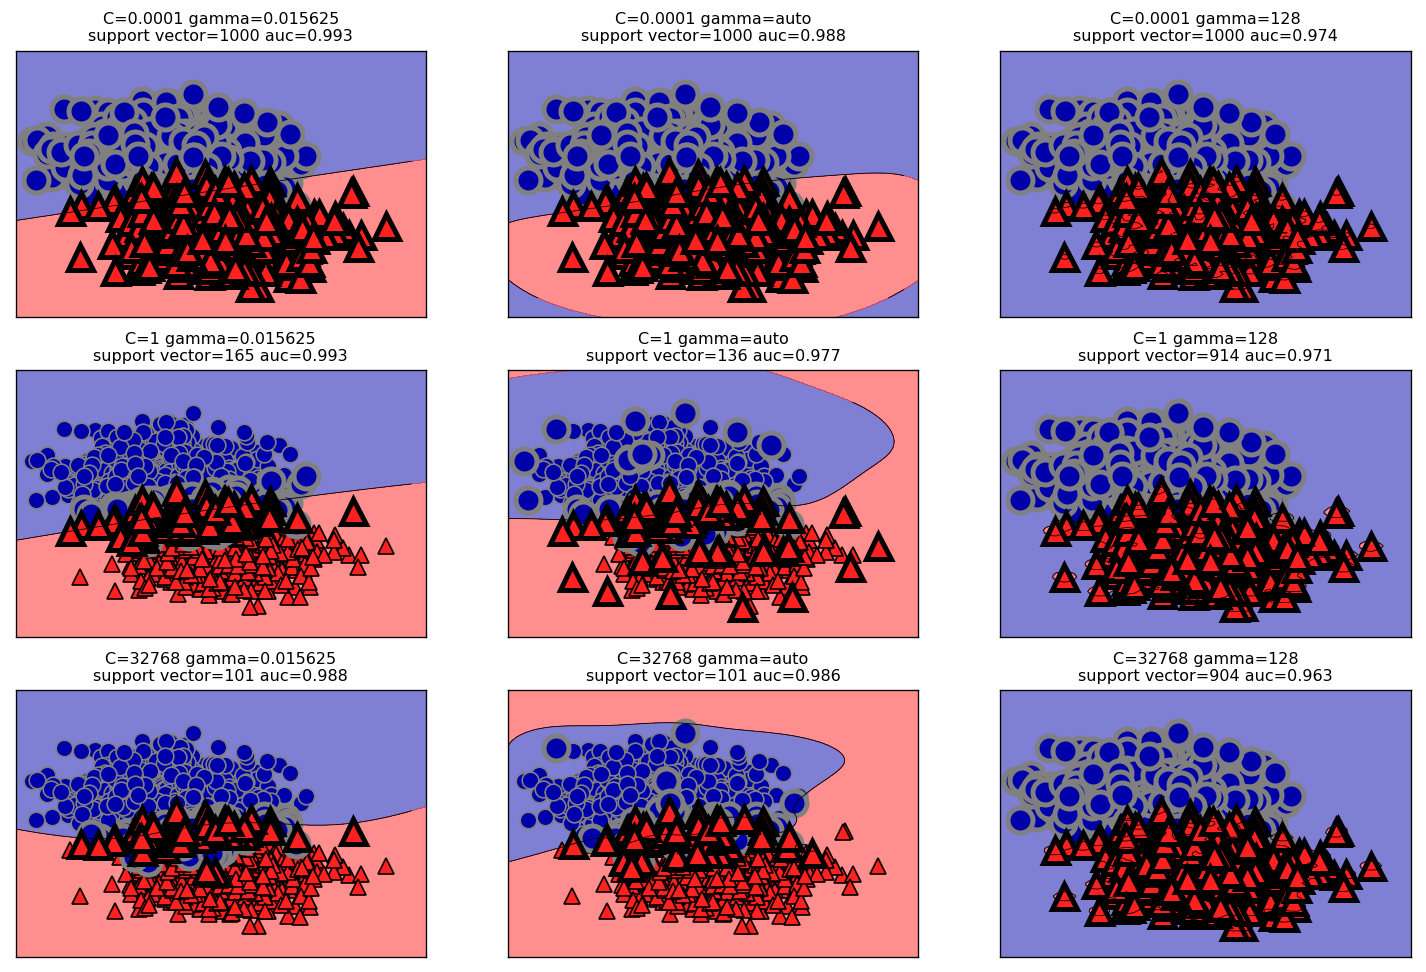

In [5]:
import mglearn
plt.figure(figsize=(15, 10));
num = 1
for c in [0.0001, 1, 32768]:
    for gamma in [0.015625, 'auto', 128]:
        clf = SVC(kernel='rbf', C=c, gamma=gamma)
        clf.fit(X, y)
        score = cross_val_score(clf, X, y, cv=10, scoring='roc_auc').mean()
        plt.subplot(3, 3, num);
        plt.title('C=%s gamma=%s\nsupport vector=%d auc=%.3f' % (
            c, gamma, clf.support_vectors_.shape[0], score))
        plot_svm(clf)
        num += 1        
plt.show();

The figure shows that small C and large $\gamma$ lead to overfitting, manifesting as more support vectors and smaller margins. Besides, when C is default value and $\gamma$ is very low, as shown in above figure when C=1 and gamma=0.015625, the SVC tend to form a linear boundary, and the AUC score is almost as good as the linear model built in the previous question.

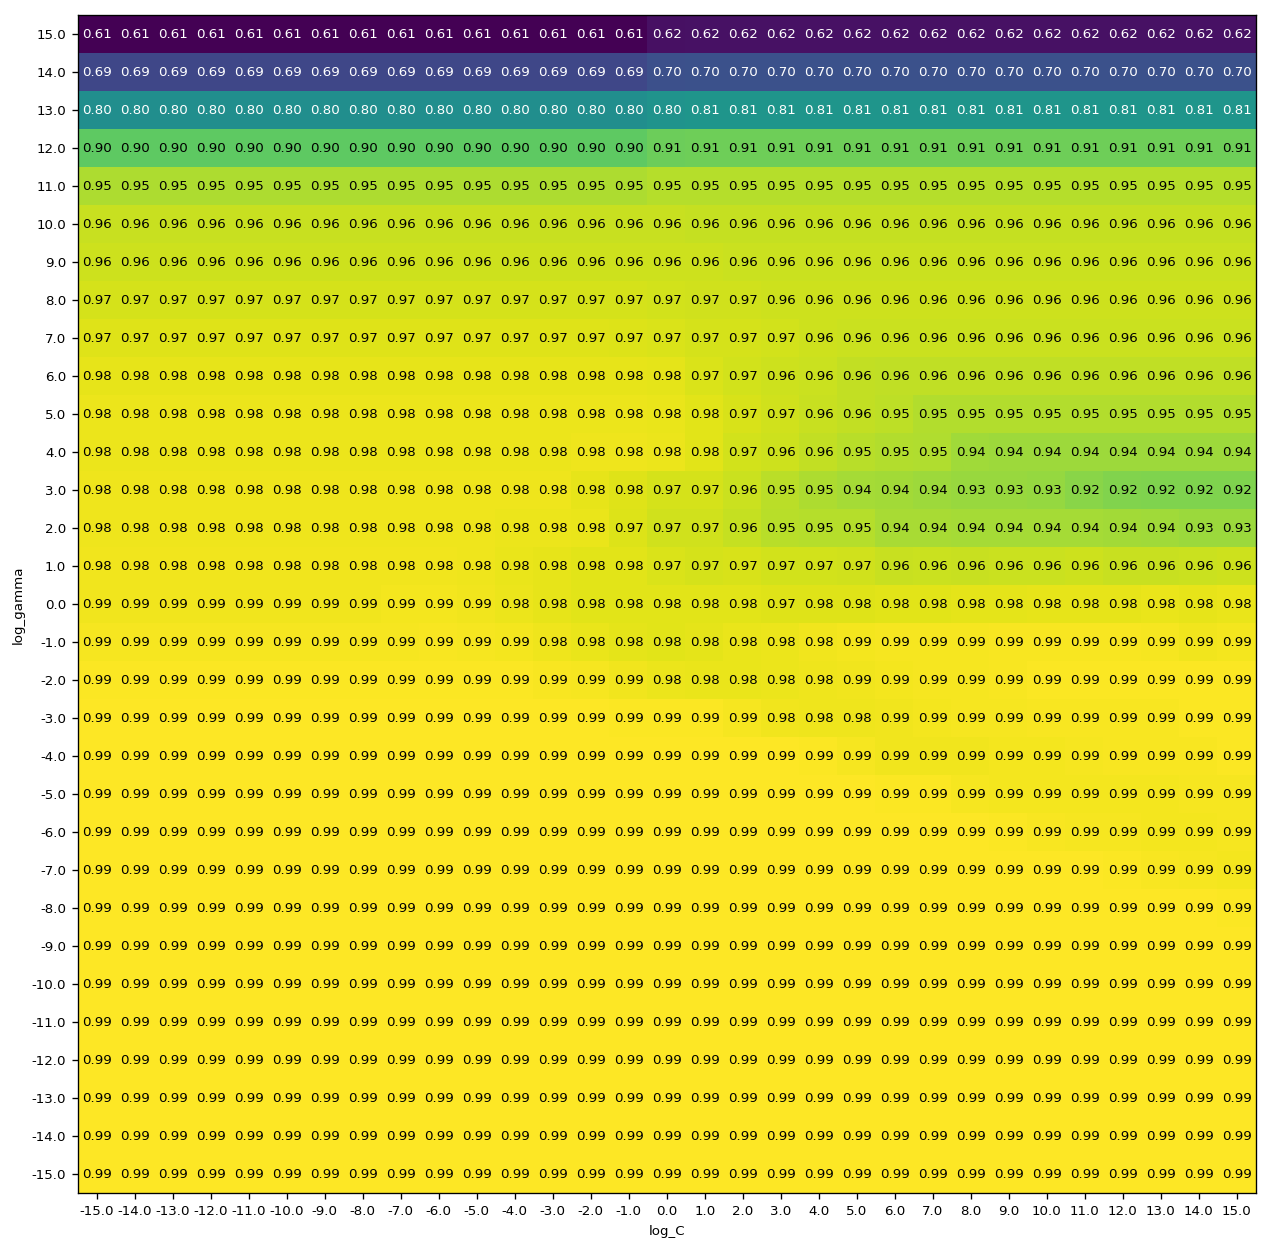

In [5]:
import pandas as pd
from matplotlib.collections import PolyCollection
import numpy as np

k = [2**x for x in range(-15, 16)]
    
param_grid = {
    'C': k,
    'gamma': k,
}

grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid,
                  cv=10, n_jobs=-1, scoring='roc_auc')
grid.fit(X, y)

results = pd.DataFrame(grid.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid['C']), len(param_grid['gamma'])).T
# plot the mean cross-validation scores
plt.figure(figsize = (13,13))
mglearn.tools.heatmap(scores, xlabel='log_C', xticklabels=np.log2(param_grid['C']),
                      ylabel='log_gamma', yticklabels=np.log2(param_grid['gamma']), cmap="viridis")
plt.show()

For this task, we vary both C and $\gamma$ in [$2^{-15}..2^{15}$] on a log scale.
It can be seen that high gamma values lead to lower auc scores. When $\gamma$ varies within range [$2^{0}..2^{7}$], higher C leads to lower AUC scores. When $\gamma$ is larger than $2^{7}$, SVC alway has bad performance no matter how C varies. Actually it is hard to tell overfitting/underfitting purely basing on AUC heatmap, because overfitting/underfitting is depending on the number of support vectors, not the AUC score. From the last task, the AUC score of overfitting cases varies from 0.963 to 0.993, and the non-overfitting cases could also vary in the same range, so we couldn't tell in which region overfitting/underfitting from heatmap.

## Robots and SVMs (4 points (2+1+1))

The [Wall Robot Navigation dataset](http://www.openml.org/d/1497) contains about 5500 readings of an ultrasound sensor array mounted on a robot, and your task is to finetune and train an SVM classifier to predict how the robot should move next.

- Make a stratified 80-20 split of the data. On the training set alone, optimize the main hyperparameters of the SVM for Accuracy with a random search. Vary at least the main kernel types (linear, polynomial, and RBF), the C parameter, the $\gamma$ parameter for the RBF kernel and the exponent/degree for the polynomial kernel. Report the optimal hyperparameter settings and Accuracy performance. 
    - The degree of the polynonial is typically in the range 2..10.
    - Hint: note that the hyperparameter ranges depend on each other. For instance, $\gamma$ only makes sense if you have selected the RBF kernel as well. We've seen in class how to define multiple hyperparameter spaces in a random/grid search.
- Use a 5x3-fold (5 outer, 3 inner) nested cross-validation (CV) on the **whole** dataset to obtain a clean evaluation. What is the mean optimized performance? Is this in line with the optimized result of the random search of the previous question?
- Train an SVM using the optimal hyperparameter configuration you found (in part 1 of this question) and test it on the held out (20%) test set. Compare this Accuracy result with the (mean) result of the nested CV. If you would build this robot in practice, how would you find the hyperparameters to use, and which performance would you expect? Is it truly necessary to tune the hyperparameters? Which hyperparameters were most important to tune?

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC


robot_data = oml.datasets.get_dataset(1497) # Download Robot data
# Get the predictors X and the labels y
X, y = robot_data.get_data(target=robot_data.default_target_attribute); 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, train_size=0.8, stratify = y, random_state=0)

k = [2**x for x in range(-15, 16)]
param_grids = [
        {'kernel': ['linear'], 'C': k},
        {'kernel': ['poly'], 'C': k, 'degree': range(1, 11)},
        {'kernel': ['rbf'], 'C': k, 'gamma': k}]
best_score = 0
best_params = None
for param in param_grids:
    rs = RandomizedSearchCV(SVC(), param_distributions=param, n_iter = 10, n_jobs=-1)
    rs.fit(X_train, y_train)
    if rs.best_score_ > best_score:
        best_score = rs.best_score_
        best_params = rs.best_params_
        best_estimator = rs.best_estimator_
print('Best AUC score: {:.3f} with params: {}'.format(best_score, best_params))

Best AUC score: 0.906 with params: {'kernel': 'rbf', 'gamma': 0.000244140625, 'C': 16384}


In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(SVC(), n_jobs=-1, param_grid = param_grids, cv = 3)
score = cross_val_score(gs, X, y, cv=5).mean()
print('cross validation score: {:.3f}'.format(score))

cross validation score: 0.861


The performance of nested cross validation is lower than the random search, but is more reliable. In the random search, we uses the same data to tune the hyperparameter and evaluate the performance of the model, this leads to information leaking and could overfit the data. While by nested cross validation, the model is evaluated by an independent test set when the optimal hyperparameters are found, so that the score is a more moderate result.

In [5]:
svm = SVC(**best_params)
svm.fit(X_train, y_train)
score = svm.score(X_test, y_test)
print('SVM with optimal para acurracy: {:.3f}'.format(score))

SVM with optimal para acurracy: 0.923


The score on test set is much higher than the mean result of nested cross validation. When build this robot in practice, we prefer to do a random search and nested cross validation to find the optimal hyperparameter. We think it is necessary to tune the hyperparameter, and the kernel is an important parameter to consider. 

## A benchmark study (3 points (2+1))

A benchmark study is an experiment in which multiple algorithms are evaluated on multiple datasets. The end goal is to study whether one algorithm is generally better than the others. Meaningful benchmark studies can grow quite complex, here we do a simplified variant.

* Download OpenML datasets 37, 470, 1120, 1464 and 1471. They are sufficiently large (e.g., at least 500 data points) so that the performance estimation is trustworthy. Select at least three classifiers that we discussed in class, e.g. kNN, Logistic Regression, Random Forests, Gradient Boosting, SVMs, Naive Bayes. Note that some of these algorithms take longer to train. Evaluate all classifiers (with default parameter settings) on all datasets, using a 10-fold CV and AUC. Show the results in a table and interpret them. Which is the best algorithm in this benchmark?
    * Note that these datasets have categorical features, different scales, missing values, and (likely) irrelevant features. You'll need to build pipelines to correctly build all models. Also remove any row identifiers (see, e.g., https://www.openml.org/d/1120)
    * Hint: You can either compare the performances directly, or (better) use a statistical significance test, e.g. a pairwise t-test or (better) Wilcoxon signed ranks test, to see whether the performance differences are significant. This is covered in statistics courses. You can then count wins, ties and losses.
* Repeat the benchmark, but now additionally optimize the main hyperparameters of each algorithm in a grid or random search (explore at least 5 values per hyperparameter, where possible). Does this affect the ranking of the algorithms?

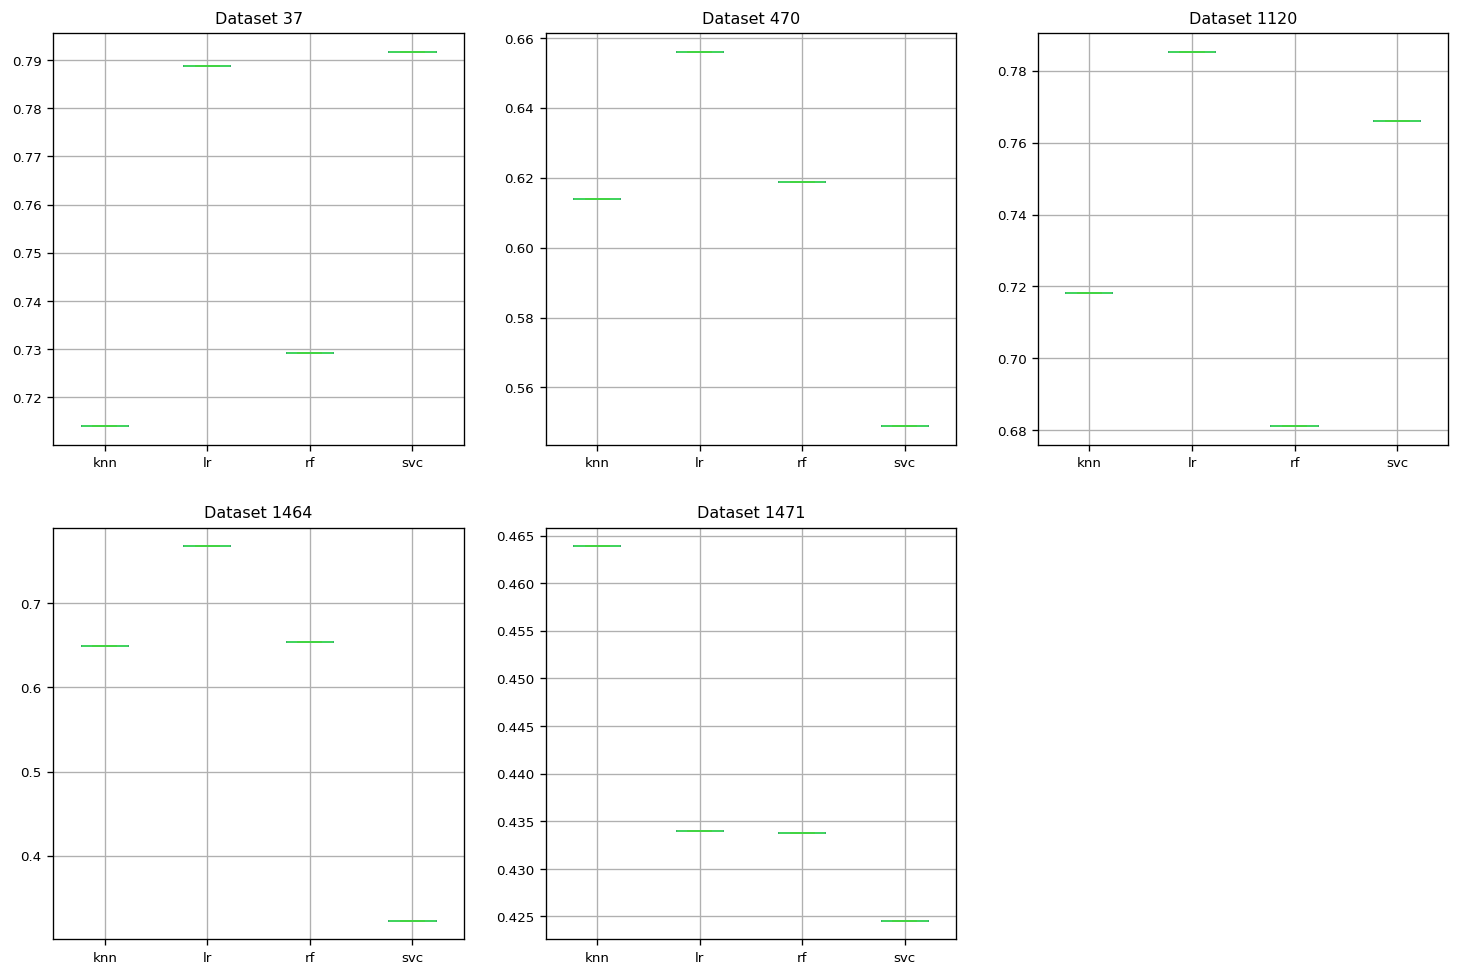

In [5]:
from sklearn import pipeline
from sklearn.preprocessing import Imputer, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import SelectPercentile, f_regression
datasets = [37, 470, 1120, 1464, 1471]

algs = [
    ('knn', KNeighborsClassifier()),
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svc', SVC())
]

plt.figure(figsize=(15, 10))
for i, ds in enumerate(datasets):
    benchmark_data = oml.datasets.get_dataset(ds)
    X, y = benchmark_data.get_data(target=benchmark_data.default_target_attribute)
    scores = []
    for name, alg in algs:
        pipe = pipeline.Pipeline(steps=[
            ('Imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)),
            ("select", SelectPercentile(score_func=f_regression, percentile=5)),
            ('scaler', MinMaxScaler()),
            ('Classifier', alg)
           ])
        scores.append(cross_val_score(pipe, X, y, n_jobs = -1, cv = 10, scoring = 'roc_auc').mean())
    scores = pd.DataFrame(scores, index=[name for name, _ in algs]);
    plt.subplot(2, 3, i+1);
    img = scores.T.boxplot();
    plt.title('Dataset %d' % ds);
plt.show()

In order to have a clear visualization of the results, the mean cross validation score of each classifier is ploted for every data set. The above result shows that performance of classifiers varies on different data set, so the choosing of classifier is depending on types of data set.

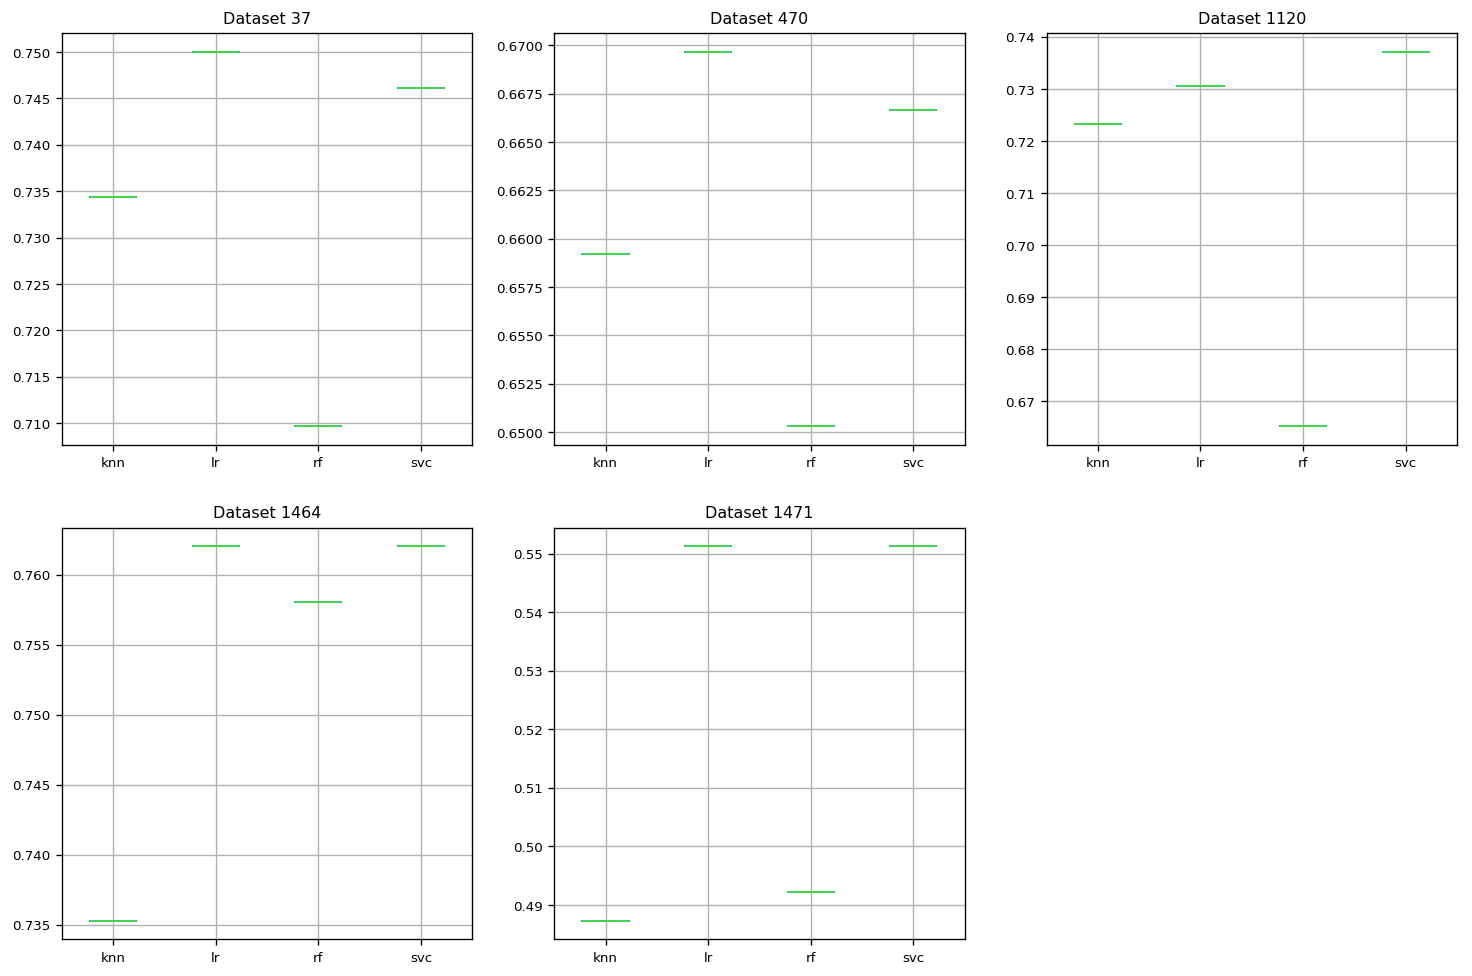

In [6]:
algs = [
    ('knn', KNeighborsClassifier(), {
        'Classifier__n_neighbors': [1, 5, 10, 15, 20]
    }),
    ('lr', LogisticRegression(), {
        'Classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
    }),
    ('rf', RandomForestClassifier(), {
        'Classifier__n_estimators': [2**i for i in range(8)]
    }),
    ('svc', SVC(), {
        'Classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
        'Classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    })
]

plt.figure(figsize=(15, 10))
for i, ds in enumerate(datasets):
    benchmark_data = oml.datasets.get_dataset(ds)
    X, y = benchmark_data.get_data(target=benchmark_data.default_target_attribute)
    scores = []
    for name, alg, gird_pa in algs:
        pipe = pipeline.Pipeline(steps=[
            ('Imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)),
            ("select", SelectPercentile(score_func=f_regression, percentile=5)),
            ('scaler', MinMaxScaler()),
            #('OneHotEncoder', OneHotEncoder(sparse=False, handle_unknown='ignore')),
            ('Classifier', alg)
           ])
        grid = GridSearchCV(pipe, param_grid = gird_pa, cv=10)
        grid.fit(X,y)
        scores.append(grid.best_score_)
    scores = pd.DataFrame(scores, index=[name for name, _, _ in algs]);
    plt.subplot(2, 3, i+1);
    img = scores.T.boxplot();
    plt.title('Dataset %d' % ds);
plt.show()

After tune the hyperparameters of all algorithms by a grid search, the ranking of the algorithms are changed for all data set. In some cases the optimized performances are similar to those with default parameters, in other cases the optimized performances are a little lower or higher than those with default settings. From the output we can also find that performance of svc in some datasets improves a lot with optimized parameters. In conclusion, it is hard to find a general trend to tell which algorithm is best.

## Gaussian Processes (2 points (1+1))

Consider the RAM prices dataset (included in the data folder). Separate the data in a training set of all data points up until the year 2000, and a test set with all points after that.

- Train several of the algorithms we have covered in the course that can handle regression. Include at least linear regression, decision tree, and RandomForest. Which ones give the best $R^2$ performance on the test set? Plot the predictions (both on the training and test data) on the figure below. Use different colors for different algorithms or build multiple plots.
- Train a Gaussian process on an increasing amount of samples of the training data. Start with 5 random sample and plot the predictions (both the mean and the uncertainty interval) for both training and test data, as shown in class. Now add 5 more points and retrain and redraw. Do this a couple of times and interpret/explain what you see. Finally, train the Gaussian on the full dataset and again show plot the predictions. Evaluate on the test set using  $R^2$. Compare these results with those achieved with other algorithms and explain.

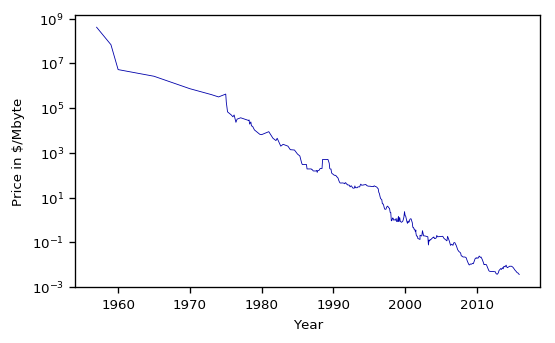

In [5]:
ram_prices = pd.read_csv('data/ram_price.csv')
plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year");
plt.ylabel("Price in $/Mbyte");

R^2 of LinearRegression : 0.83
R^2 of DecisionTreeRegressor : -5.23
R^2 of RandomForestRegressor : -4.59


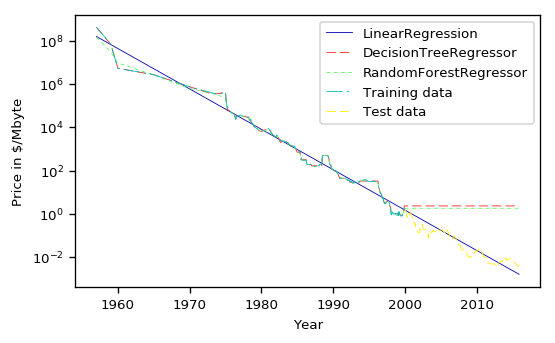

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date:
X_train = data_train.date[:, np.newaxis]
# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

X_test = data_test.date[:, np.newaxis]
# we use a log-transform to get a simpler relationship of data to target
y_test = np.log(data_test.price)

# predict on all data
X_all = ram_prices.date[:, np.newaxis]
y_all = np.log(ram_prices.price)


def get_lr():
    lr = LinearRegression();
    lr.fit(X_train, y_train);
    return lr, lr.score(X_test, y_test)


def get_dt():
    grid = {
        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]
    }
    rs = GridSearchCV(DecisionTreeRegressor(), cv=5, n_jobs=-1, param_grid=grid)
    rs.fit(X_train, y_train);
    return rs.best_estimator_, r2_score(y_test, rs.predict(X_test))


def get_rf():
    grid = {
        'n_estimators': [2**i for i in range(10)],
    }
    rs = GridSearchCV(RandomForestRegressor(), cv=5, n_jobs=-1, param_grid=grid)
    rs.fit(X_train, y_train);
    return rs.best_estimator_, r2_score(y_test, rs.predict(X_test))


models = [
    get_lr(),
    get_dt(),
    get_rf()
]

for m, r2 in models:
    plt.semilogy(ram_prices.date, np.exp(m.predict(X_all)), label=m.__class__.__name__)
    print('R^2 of %s : %.3g' % (m.__class__.__name__, r2));
    
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.legend(loc='auto')
plt.xlabel('Year');
plt.ylabel('Price in $/Mbyte')


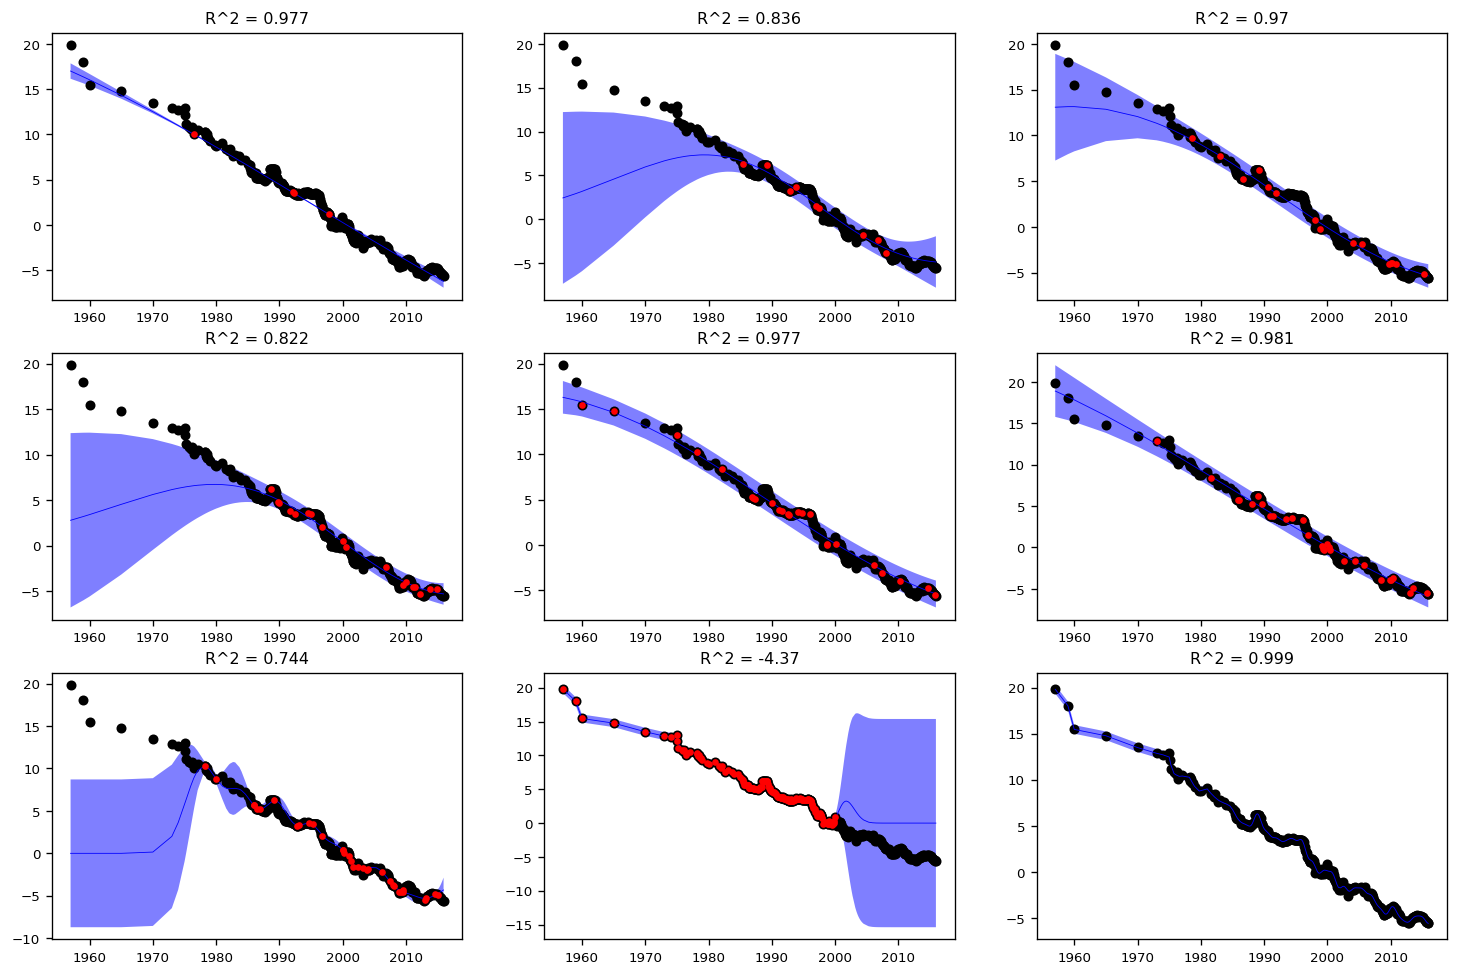

In [15]:
con = []
for t in [5, 10, 15, 20, 25, 30, 35]:
    con.append(ram_prices.index.isin(np.random.randint(len(ram_prices), size=t)))
    
def sample_data(condition):
    data_train1 = ram_prices[condition]
    data_test1 = ram_prices[~condition]
    # predict prices based on date:
    X_train1 = data_train1.date[:, np.newaxis]
    # we use a log-transform to get a simpler relationship of data to target
    y_train1 = np.log(data_train1.price)

    X_test1 = data_test1.date[:, np.newaxis]
    # we use a log-transform to get a simpler relationship of data to target
    y_test1 = np.log(data_test1.price)
    return (X_train1, y_train1), (X_test1, y_test1)

data_list = [
    sample_data(con[0]),
    sample_data(con[1]),
    sample_data(con[2]),
    sample_data(con[3]),
    sample_data(con[4]),
    sample_data(con[5]),
    sample_data(con[6]),
    ((X_train, y_train), (X_test, y_test)),
    ((X_all, y_all), ([], []))
]

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import kernels

fig = plt.figure(figsize=(15, 10))
for i, ((Xtr, ytr), (Xtst, ytst)) in enumerate(data_list):
    #kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    kernel = kernels.WhiteKernel(1.0, (1e-3, 1e1)) + C(1.0, (1e-5, 1e5)) * RBF(10.0, (1e-5, 1e5))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(Xtr, ytr)    
    y_pred, sigma = gp.predict(X_all, return_std=True)
                                      
    plt.subplot(3, 3, i + 1)
    plt.plot(X_all, y_all, 'k.', markersize=10, label=u'Observations')
    plt.plot(X_all, y_pred, 'b-', label=u'Prediction');
    plt.fill(np.concatenate([X_all, X_all[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')                                
    if i < 8:
        plt.plot(Xtr, ytr, 'r.');
        r2 = gp.score(Xtst, ytst);
    else:
        r2 = gp.score(Xtr, ytr);

    plt.title('R^2 = %.3g' % r2)

We can find that even with few training points like 5 samples, the predictions can be much better than those with more samples. And we find when the samples distribute uniformly, the prediction results can be pretty good. When training all the data before 2000, it leads to overfiting.

In the previous question, the performance of decision tree and random forests are very poor. The best R^2 score is achieved by linear regressor. 

## A mini-data mining challenge (2 points (+1))

The goal here is to use everything you have learned to build the best model for a given classification task. The task is hosted on OpenML, so you will receive the train-test splits, and your model will be evaluated on the server. The goal is to reasonably select algorithms and hyperparameter settings to obtain the best model. You can also do model selection and parameter optimization as you have done before. Skeleton code is provided in the OpenML tutorial.

- All details can be found online:
    - The OpenML Task ID is 145677: https://www.openml.org/t/145677
    - The dataset description can be found here: https://www.openml.org/d/4134
- A leaderboard is kept of the best models: https://www.openml.org/t/145677#!people
    - You are able to see the solutions of others (by clicking in the timeline or run list), but resubmission of the exact same solution does not register on the leaderboard.
    - You can share one account (one API key) per team. In case you use two, we take the one that performs best.
- You can document the different experiments that you ran in this notebook. For each experiment, provide a description of how you chose the algorithms and parameters that you submitted. Try to reason about which experiments to try, don't just do an immense random search.
- Points are rewarded as follows:
    - 1 point for the breadth of experiments you ran (algorithms, hyperparameter settings)
    - 1 point for reasoning/insight and interpretation of the results
    - 1 (bonus) point for every team who has uploaded the best solution thus far **on AUC** (who reaches the top of the leaderboard at any moment during the assignment)
        - Note: On the leaderboard page, the 'frontier' line is drawn, and your top ranking is also shown in the table.
        
Note: Report AUC scores in your report as well. In case of issues with OpenML we will use the experiments and scores mentioned your report.

In [3]:
from sklearn import pipeline
from openml import runs, datasets
from sklearn.preprocessing import Imputer, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import SelectPercentile, f_regression

# Import task
task = oml.tasks.get_task(145677)

In [4]:
# experiment 1: Grid search with knn or randomforest
algs = [
    ('knn', KNeighborsClassifier(), {
        'Classifier__n_neighbors': [1, 3, 5, 7, 10]}),
    ('rf', RandomForestClassifier(n_jobs=-1), {
        'Classifier__n_estimators': [2**5, 2**7, 2**10],
        'Classifier__max_features': [1, 3, 5]}),
    ('svm', SVC(kernel='rbf', probability=True), {
        'Classifier__gamma': [0.01, 0.1, 1, 10],
        'Classifier__C': [0.01, 0.1, 1, 10]}
    )]

for name, alg, grid_pa in algs:
    pipe = pipeline.Pipeline(steps=[
            ('Imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)),
            ("select", SelectPercentile(score_func=f_regression, percentile=5)),
            ('scaler', MinMaxScaler()),
            ('Classifier', alg)
           ])    
    grid = GridSearchCV(pipe, param_grid=grid_pa, cv=10, n_jobs=-1, scoring='roc_auc')
    run = runs.run_task(task, grid)
# Share the run on OpenML server    
    myrun = run.publish()
    print("Uploaded to http://www.openml.org/r/" + str(myrun.run_id))


Uploaded to http://www.openml.org/r/1852582
Uploaded to http://www.openml.org/r/1852589
Uploaded to http://www.openml.org/r/1852613
